In [403]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test pipeline on one instance


In [404]:
from pathlib import Path
import librosa
import IPython.display as ipd
from pitch_estimator import PitchEstimator
import matplotlib.pyplot as plt
import numpy as np
import crepe
import utils as u
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import pickle

In [405]:
# Initialize objects and variables
audio_file_path = "audios/barasvara+1.wav"
pitch_est = PitchEstimator()

# Display input audio
y, sr = librosa.load(audio_file_path, duration=30)
print("Input audio:")
display(ipd.Audio(y, rate=sr))

spectrogram = np.abs(librosa.stft(y))

# Use median filtering to divide harmonic from percussive component
# NOTE: you can change margin and kernel_size and see the effect
# margin is related to the wiener-soft-mask
# kernel is the size of the filters that go over the spectrogram
harmonic, percussive = librosa.decompose.hpss(spectrogram, margin=16, kernel_size=31)

# Reconstruct harmonic component audio and display it
harmonic_audio = librosa.griffinlim(harmonic)
print("Harmonic component:")
display(ipd.Audio(harmonic_audio, rate=sr))

# Reconstruct harmonic component audio and display it
percussive_audio = librosa.griffinlim(percussive)
print("Percussive component:")
display(ipd.Audio(percussive_audio, rate=sr))

Input audio:


Harmonic component:


Percussive component:


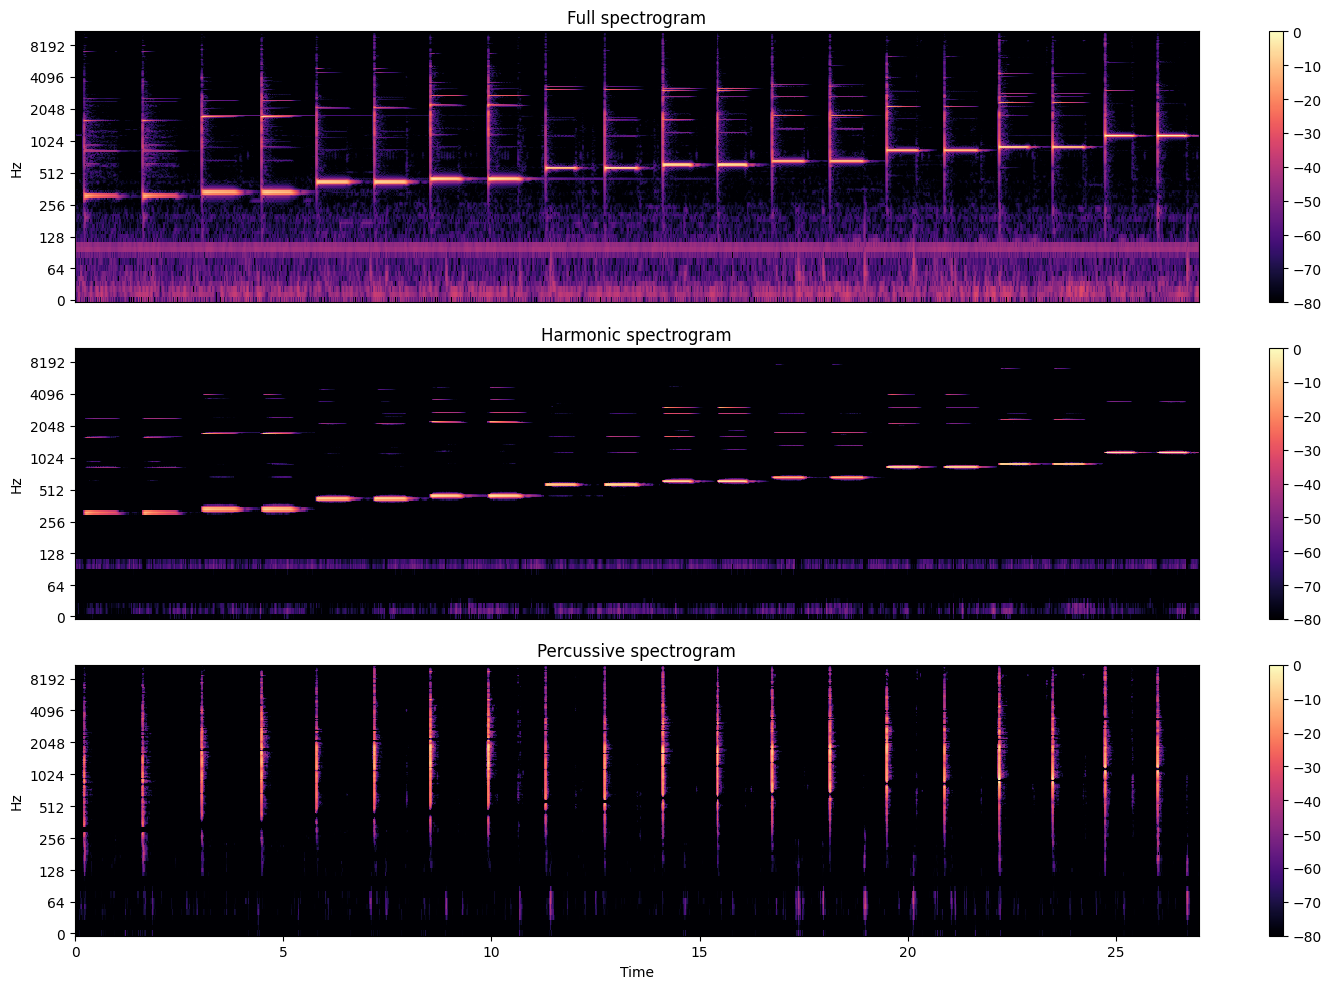

In [406]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Full spectrogram")

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(harmonic), ref=np.max), y_axis="log")
plt.colorbar()
plt.title("Harmonic spectrogram")

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(percussive), ref=np.max), y_axis="log", x_axis="time")
plt.colorbar()
plt.title("Percussive spectrogram")
plt.tight_layout()

plt.show()

In [407]:
# comps, acts = librosa.decompose.decompose(spectrogram)

In [408]:
# librosa.display.specshow(librosa.amplitude_to_db(comps, ref=np.max), y_axis="log")

In [409]:
# librosa.display.specshow(librosa.amplitude_to_db(acts, ref=np.max), y_axis="log")

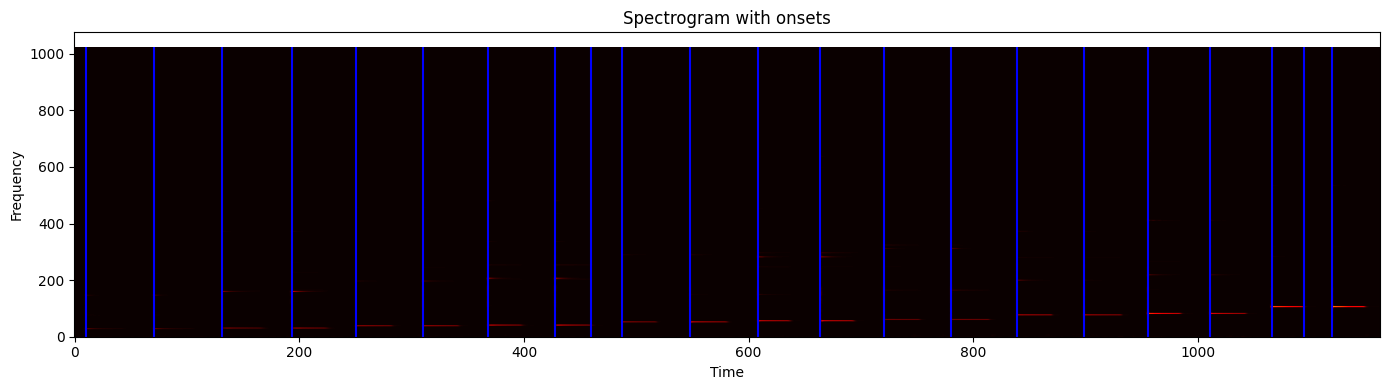

In [410]:
onset_indexes = librosa.onset.onset_detect(y=percussive_audio, sr=sr)

# Create subplots
fig, ax = plt.subplots(figsize=(14, 4))

# Plot the spectrogram
ax.imshow(spectrogram, aspect="auto", origin="lower", cmap="hot")

# Plot vertical lines at onset indices
for onset_index in onset_indexes:
    ax.vlines(onset_index, 0, spectrogram.shape[0], color="blue", linestyle="-")

# Set labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Frequency")
ax.set_title("Spectrogram with onsets")

# Adjust the layout
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

In [411]:
onsets = librosa.onset.onset_detect(y=percussive_audio, units="time")

In [412]:
time, frequency, confidence, activation = crepe.predict(harmonic_audio, sr, viterbi=True)

85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step


## Comparing CREPE with DSP techiniques

In [413]:
def detect_pitch(S, sr):
    # https://stackoverflow.com/questions/43877971/librosa-pitch-tracking-stft"""
    pitches, magnitudes = librosa.core.piptrack(S=S, sr=sr, fmin=75, fmax=1600)
    # get indexes of the maximum value in each time slice
    max_indexes = np.argmax(magnitudes, axis=0)
    # get the pitches of the max indexes per time slice
    pitches = pitches[max_indexes, range(magnitudes.shape[1])]
    return pitches

pitches_dsp = detect_pitch(S=harmonic, sr=sr)

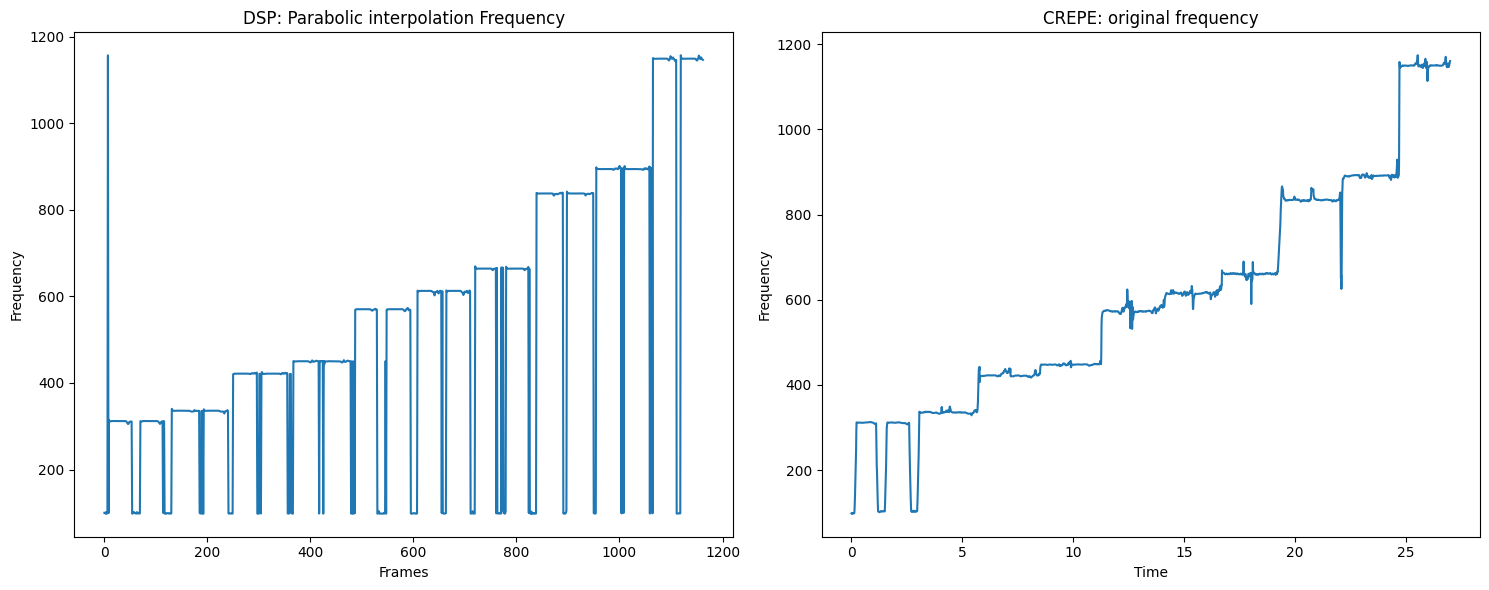

In [414]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 6))

frames = np.arange(len(pitches_dsp))
# Plot new_frequency
ax.plot(frames, pitches_dsp)
ax.set_xlabel("Frames")
ax.set_ylabel("Frequency")
ax.set_title("DSP: Parabolic interpolation Frequency")

# Plot frequency
ax2.plot(time, frequency)
ax2.set_xlabel("Time")
ax2.set_ylabel("Frequency")
ax2.set_title("CREPE: original frequency")

plt.tight_layout()
plt.show()

In [415]:
def find_stable_regions(frequencies, window_size, threshold):
    stable_regions = []
    segments = []
    for i in range(len(frequencies) - window_size + 1):
        segment = frequencies[i:i+window_size]
        std_dev = np.std(segment)
        if std_dev < threshold:
            stable_regions.append((i, i+window_size))
            # segments.append( ( np.mean(segment), np.median(segment) ) )
            segments.append(round(np.mean(segment), 2))
    return stable_regions, segments


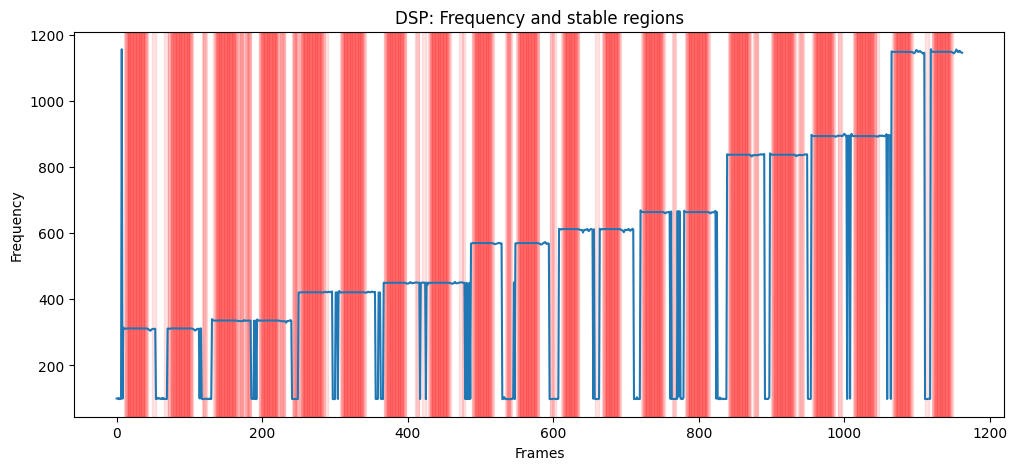

In [416]:
# windows size and threshold can be tweaked
stable_r, segs = find_stable_regions(frequencies=pitches_dsp, window_size=5, threshold=0.4)
fig, ax = plt.subplots(figsize=(12,5))

# Plot the frequency values
ax.plot(frames, pitches_dsp)
ax.set_xlabel("Frames")
ax.set_ylabel("Frequency")
ax.set_title("DSP: Frequency and stable regions")

for start, end in stable_r:
    plt.axvspan(start, end, color='red', alpha=0.1)

plt.show()

In [417]:
# new_frequency = frequency.copy()
# new_frequency[confidence < 0.6] = 0

In [418]:
# fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# # Plot new_frequency
# ax.plot(time, new_frequency)
# ax.set_xlabel("Time")
# ax.set_ylabel("Frequency")
# ax.set_title("New Frequency")

# # Plot frequency
# ax2.plot(time, frequency)
# ax2.set_xlabel("Time")
# ax2.set_ylabel("Frequency")
# ax2.set_title("Original Frequency")

# plt.tight_layout()
# plt.show()

In [419]:
# tones = []
# stable_segments_idxs = []


# for i, onset in enumerate(onsets):
#     index_a = np.argmax(time > onset)
#     if i == len(onsets) - 1:
#         index_b = len(time) - 1
#     else:
#         index_b = np.argmax(time > onsets[i + 1])

#     frequency_segment = new_frequency[index_a:index_b]
#     no_zero_seg = frequency_segment[frequency_segment != 0]
#     # print(frequency_segment)
#     # print(no_zero_seg)

#     tone = np.median(frequency_segment)
#     # tone = np.median(frequency_segment[frequency_segment > 0])
#     if tone == 0:
#         continue
#     print(f"Onset median {i}-{i+1}: {tone}")

#     print("----------")
#     tones.append(tone)

In [420]:
# tone_group = u.group_and_average_frequencies(tones)
tone_group = u.group_and_average_frequencies(segs)

def filter_list(input_list):
    return [item for item in input_list if 120 <= item <= 2000]

tone_group = filter_list(tone_group)

In [421]:
for tone in tone_group:
    audio = librosa.tone(tone, duration=1)
    print(f"Playing tone {tone}")
    display(ipd.Audio(audio, rate=sr))

wait_time = 0.5
audio = np.array([])
for tone in tone_group:
    tone_audio = librosa.tone(tone, duration=1)
    wait_audio = np.zeros(int(wait_time * sr))
    audio = np.concatenate((audio, tone_audio, wait_audio))

print("Playing concatenated audio:")
display(ipd.Audio(audio, rate=sr))

Playing tone 311.9768325805664


Playing tone 335.74646848790786


Playing tone 421.4831741575211


Playing tone 450.16271403684453


Playing tone 570.34406986943


Playing tone 612.6893097633539


Playing tone 664.1265416638605


Playing tone 837.5510911941528


Playing tone 894.0750069453799


Playing tone 1148.980413942921


Playing concatenated audio:


## Find out the tuning


In [422]:
def compute_distance(tone_a, tone_b):
    distance_in_cents = 1200 * np.log2(tone_b / tone_a)
    return distance_in_cents

distances = []

for i in range(len(tone_group) - 1):
    tone_a = tone_group[i]
    tone_b = tone_group[i + 1]
    d = compute_distance(tone_a, tone_b)
    print(f"Distance between {tone_a} and {tone_b}: {d} cents")
    distances.append(d)

Distance between 311.9768325805664 and 335.74646848790786: 127.11999175750287 cents
Distance between 335.74646848790786 and 421.4831741575211: 393.7233770700356 cents
Distance between 421.4831741575211 and 450.16271403684453: 113.96583291853077 cents
Distance between 450.16271403684453 and 570.34406986943: 409.66313512640033 cents
Distance between 570.34406986943 and 612.6893097633539: 123.98780017512685 cents
Distance between 612.6893097633539 and 664.1265416638605: 139.562972851182 cents
Distance between 664.1265416638605 and 837.5510911941528: 401.6628502149239 cents
Distance between 837.5510911941528 and 894.0750069453799: 113.06240456150823 cents
Distance between 894.0750069453799 and 1148.980413942921: 434.26371746967095 cents


In [423]:
scale_successful = False
for i in range(len(distances) - 1):
    if distances[i] < 200 and distances[i + 1] < 200:
        print(f"Found two consecutive values smaller than 220: {distances[i]} and {distances[i+1]}")
        scale = tone_group[i : i + 6]

        if len(scale) < 6:
            print(f"Could not find a complete scale... only found {len(scale)} tones")
            break
        
        scale_successful = True # TODO: fix this, as it is not necessarily true at this point

        print("---")
        ding, dong, deng, dung, dang, hiding = scale
        print(f"Ding: {ding}")
        print(f"Dong: {dong}")
        print(f"Deng: {deng}")
        print(f"Dung: {dung}")
        print(f"Dang: {dang}")
        print(f"Hiding: {hiding}")
        print("---")
        scale_distances = np.array(distances[i : i + 5])
        print(f"Scale distances: {scale_distances}")

Found two consecutive values smaller than 220: 123.98780017512685 and 139.562972851182
---
Ding: 570.34406986943
Dong: 612.6893097633539
Deng: 664.1265416638605
Dung: 837.5510911941528
Dang: 894.0750069453799
Hiding: 1148.980413942921
---
Scale distances: [123.98780018 139.56297285 401.66285021 113.06240456 434.26371747]


In [424]:
if scale_successful:
    begbeg = np.array([120, 114, 432, 81, 453])
    sedang = np.array([136, 155, 379, 134, 396])
    tirus = np.array([197, 180, 347, 104, 372])

    similarity = cosine_similarity([scale_distances], [begbeg, sedang, tirus])[0]
    max_similarity = np.max(similarity)
    print(f"Cosine similarity to begbeg: {similarity[0]}{' *winner*' if similarity[0] == max_similarity else ''}")
    print(f"Cosine similarity to sedang: {similarity[1]}{' *winner*' if similarity[1] == max_similarity else ''}")
    print(f"Cosine similarity to tirus: {similarity[2]}{' *winner*' if similarity[2] == max_similarity else ''}")
    print("-------")

    eucl_distances = euclidean_distances(X=[scale_distances], Y=[begbeg, sedang, tirus])[0]
    min_distance = np.min(eucl_distances)
    print(f"Euclidian distance to begbeg: {eucl_distances[0]}{' *winner*' if eucl_distances[0] == min_distance else ''}")
    print(f"Euclidian distance to sedang: {eucl_distances[1]}{' *winner*' if eucl_distances[1] == min_distance else ''}")
    print(f"Euclidian distance to tirus: {eucl_distances[2]}{' *winner*' if eucl_distances[2] == min_distance else ''}")
    print("-------")

    def gaussian_kernel(x, y, sigma=100):
        distance_squared = np.sum((x - y) ** 2)
        kernel_value = np.exp(-distance_squared / (2 * sigma**2))
        return kernel_value

    gaussian_results = {
        'begbeg': gaussian_kernel(scale_distances, begbeg),
        'sedang': gaussian_kernel(scale_distances, sedang),
        'tirus': gaussian_kernel(scale_distances, tirus)
    }
    max_similarity = max(gaussian_results.values())
    for key, value in gaussian_results.items():
        print(f"Gaussian similarity to {key}: {value}{' *winner*' if value == max_similarity else ''}")

Cosine similarity to begbeg: 0.9969807954639205
Cosine similarity to sedang: 0.9974732561467409 *winner*
Cosine similarity to tirus: 0.9840665387881651
-------
Euclidian distance to begbeg: 54.48629972416243
Euclidian distance to sedang: 52.90268905296649 *winner*
Euclidian distance to tirus: 117.95278449913799
-------
Gaussian similarity to begbeg: 0.862053588272242
Gaussian similarity to sedang: 0.8694149842170018 *winner*
Gaussian similarity to tirus: 0.4987536619471938


## Compute region similarity

In [425]:
dataset_df = pickle.load(open("pickles/dataset.pkl", "rb"))

In [426]:
dataset_df

Region           Gamelan Flavor  ding3  dong3  deng3  dung3  dang3  \
0    Gianyar          Sumampan      -  553.1  595.2  644.6  810.7  873.4   
1    Gianyar          Sumampan      -  554.4  597.9  647.2  813.5  880.0   
2    Gianyar          Sumampan      +  561.5  603.1  652.1  818.2  883.1   
3    Gianyar          Sumampan      +  561.5  603.1  652.1  818.2  883.1   
4    Gianyar          Sumampan      -  553.1  595.2  644.6  810.7  873.4   
..       ...               ...    ...    ...    ...    ...    ...    ...   
317   Bangli  Blungbang Bangli      +  484.3  533.0  582.9  738.7  848.1   
318   Bangli  Blungbang Bangli      +  482.9  532.4  585.0  732.8  848.6   
319   Bangli  Blungbang Bangli      +  484.3  533.0  582.9  738.7  848.1   
320   Bangli  Blungbang Bangli      -  479.0  531.5  574.9  726.4  807.9   
321   Bangli  Blungbang Bangli      -  476.5  525.1  573.9  734.0  802.8   

      ding4  
0    1115.2  
1    1117.1  
2    1124.9  
3    1124.9  
4    1115.2  
..      ...  
317   992.3  
318   993.5  
319   992.3  
320   986.1  
321   983.2  

[322 rows x 9 columns]

In [427]:
# filtered_dataset = dataset_df[dataset_df['Flavor'] == '+']
all_scales = dataset_df.iloc[:, 3:9].values

In [428]:
all_scales

array([[ 553.1,  595.2,  644.6,  810.7,  873.4, 1115.2],
       [ 554.4,  597.9,  647.2,  813.5,  880. , 1117.1],
       [ 561.5,  603.1,  652.1,  818.2,  883.1, 1124.9],
       ...,
       [ 484.3,  533. ,  582.9,  738.7,  848.1,  992.3],
       [ 479. ,  531.5,  574.9,  726.4,  807.9,  986.1],
       [ 476.5,  525.1,  573.9,  734. ,  802.8,  983.2]])

In [429]:
all_distances = []
for scale in all_scales:
    dist = []
    for i in range(len(scale) - 1):
        tone_a = scale[i]
        tone_b = scale[i + 1]
        d = compute_distance(tone_a, tone_b)
        # print(f"Distance between {tone_a} and {tone_b}: {d} cents")
        dist.append(d)
    all_distances.append(dist)

In [430]:
similarities = []
max_similarity = 0
max_similarity_index = 0
for i, distance in enumerate(all_distances):
    similarity = cosine_similarity([distance], [scale_distances])[0][0]
    similarities.append(similarity)
    if similarity > max_similarity:
        max_similarity = similarity
        max_similarity_index = i
print(f"Max similarity: {max_similarity} at index {max_similarity_index}")

Max similarity: 0.9995445613449113 at index 0


In [431]:
dataset_df.iloc[max_similarity_index]

Region      Gianyar
Gamelan    Sumampan
Flavor            -
ding3         553.1
dong3         595.2
deng3         644.6
dung3         810.7
dang3         873.4
ding4        1115.2
Name: 0, dtype: object